In [2]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from typing import List, Tuple
from collections import OrderedDict

import tqdm
import pathlib
import numpy as np
import numba as nb
import pandas as pd
import pylab as plt

import tttrlib

In [3]:
def make_2d_plot(
    x, y, 
    range_x,
    range_y,
    paris_folder: pathlib.Path,
    xlabel: str = "x", 
    ylabel: str = "y",
    bins_x: int = 100,
    bins_y: int = 100,
    log_x: bool = False,
    log_y: bool = False
): 
    # Define logarithmic bins if required
    if log_x:
        bins_x = np.logspace(np.log10(range_x[0]), np.log10(range_x[1]), bins_x)
    else:
        bins_x = np.linspace(range_x[0], range_x[1], bins_x)
        
    if log_y:
        bins_y = np.logspace(np.log10(range_y[0]), np.log10(range_y[1]), bins_y)
    else:
        bins_y = np.linspace(range_y[0], range_y[1], bins_y)
    
    # 1. Define function for 2D histogram (e.g., for SPIE vs EFRET)
    def scatter_hist(x, y, ax, ax_histx, ax_histy):
        # Labels of the marginal distribution
        ax_histx.tick_params(axis="x", labelbottom=False)
        ax_histy.tick_params(axis="y", labelleft=False)
        
        # 2D histogram with optional log scaling
        hist2D = ax.hist2d(x, y, bins=[bins_x, bins_y], cmap='Greys', density=False)
        
        # Marginal distributions
        xhist = ax_histx.hist(x, bins=bins_x, color="dimgrey")
        yhist = ax_histy.hist(y, bins=bins_y, color="darkorange", orientation='horizontal')
    
        return hist2D, xhist, yhist
    
    # 2. Define a grid
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height, width, 0.2]
    rect_histy = [left + width, bottom, 0.2, height]
    
    # 3. Plot the results
    fig = plt.figure(figsize=(8, 8))

    ax = fig.add_axes(rect_scatter)
    ax.set_xlabel(xlabel, fontsize=16,  fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=16,  fontweight='bold')
    ax_histx = fig.add_axes(rect_histx, sharex=ax)
    ax_histy = fig.add_axes(rect_histy, sharey=ax)

    # Apply log scaling to the axes if required
    if log_x:
        ax.set_xscale("log")
        ax_histx.set_xscale("log")
    if log_y:
        ax.set_yscale("log")
        ax_histy.set_yscale("log")

    # Set font sizes for tick labels
    for label in (ax.get_xticklabels() + ax.get_yticklabels() + ax_histx.get_yticklabels() + ax_histy.get_xticklabels()):
        label.set_fontsize(14)

    # 4. Plot and save plot
    filename = paris_folder.as_posix() + "/"
    xy2D, x_1D, y_1D = scatter_hist(x, y, ax, ax_histx, ax_histy)
    
    plt.savefig(filename + '2D_' + xlabel + '-' + ylabel + '.png')
    plt.show()
    plt.close()


In [4]:
@nb.jit(nopython=True)
def get_indices_in_ranges(rout, mt, chs, micro_time_ranges):
    # Create a boolean mask for the rout values in chs
    rout_mask = np.zeros(rout.shape, dtype=np.bool_)
    for ch in chs:
        rout_mask |= (rout == ch)

    # Create a boolean mask for the mt values in micro_time_ranges
    mt_mask = np.zeros(mt.shape, dtype=np.bool_)
    for start, end in micro_time_ranges:
        mt_mask |= (mt >= start) & (mt <= end)

    # Get indices where both masks are true
    indices = np.where(rout_mask & mt_mask)[0]

    return indices

In [5]:
def find_bursts(arr, max_gap=0):
    """
    Identifies sequences (bursts) of consecutive ones in a binary array and optionally merges small gaps between them.

    The function detects where the array changes from 0 to 1 (indicating the start of a burst) and 1 to 0
    (indicating the end of a burst). If `max_gap` is greater than 0, gaps smaller than or equal to `max_gap`
    between consecutive bursts are merged.

    Parameters:
    arr (numpy array): A binary array (containing 0s and 1s) where the function will identify bursts of ones.
    max_gap (int, optional): The maximum gap size between bursts that can be merged. Default is 0 (no merging).

    Returns:
    numpy array: A 2D array where each row contains the start and end indices (inclusive) of each burst.

    Example:
    --------
    >>> arr = np.array([0, 1, 1, 0, 0, 1, 1, 1, 0])
    >>> find_bursts(arr)
    array([[1, 2],
           [5, 7]])

    >>> find_bursts(arr, max_gap=1)
    array([[1, 7]])
    """
    # Find where the array changes from 0 to 1 (start of burst) and 1 to 0 (end of burst)
    is_burst = np.diff(arr, prepend=0, append=0)
    starts = np.where(is_burst == 1)[0]
    stops = np.where(is_burst == -1)[0]

    # If max_gap is greater than 0, merge small gaps
    if max_gap > 0:
        merged_starts = [starts[0]]  # Initialize with the first start
        merged_stops = []

        for i in range(1, len(starts)):
            # Check if the gap between current stop and next start is small enough to merge
            if starts[i] - stops[i - 1] - 1 <= max_gap:
                continue  # Skip this start, effectively merging
            else:
                merged_stops.append(stops[i - 1])
                merged_starts.append(starts[i])

        # Append the final stop
        merged_stops.append(stops[-1])

        # Convert merged lists to NumPy arrays
        starts = np.array(merged_starts)
        stops = np.array(merged_stops)

    # Stack the starts and stops into a 2D array
    bursts = np.column_stack((starts, stops - 1))  # stop is exclusive, so subtract 1

    return bursts

In [6]:
@nb.jit(nopython=True)
def create_array_with_ones(start_stop_pairs, length):
    arr = np.zeros(length, dtype=np.uint8)  # Create an array of zeros with the specified length
    for start, stop in start_stop_pairs:
        arr[start:stop] = 1  # Set values between start and stop to one
    return arr

In [7]:
def select_photons(
    tttr: tttrlib.TTTR, 
    chs: List[int], 
    dT_max: float,
    microtime_ranges: List[Tuple[int, int]],
    filter_options: dict = None,
    used_filter: str = 'burstwise',
    min_ph: int = 10,
    ph_window: int = 10,
    tw: float = 5
):
    
    mT = tttr.macro_times
    dT = np.diff(mT, prepend=mT[0])
    s = np.ones_like(dT, dtype=bool)

    if chs:
        mask = tttrlib.TTTRMask()
        mask.select_channels(tttr, chs, mask=True)
        m = mask.get_mask()
        s = np.logical_and(s, m)

    if microtime_ranges:
        mask = tttrlib.TTTRMask()
        mask.select_microtime_ranges(tttr, microtime_ranges)
        mask.flip()
        m = mask.get_mask()
        s = np.logical_and(s, m)
    
    # header = tttr.header
    # res = header.macro_time_resolution
    # if isinstance(dT_max, float):
    #     dT_max = int(dT_max / (1000. * res))
    #     s = np.logical_and(s, dT <= dT_max)

    start_stop = np.array(tttr.burst_search(min_ph, ph_window, tw / 1000.0))
    start_stop = start_stop.reshape((len(start_stop) // 2, 2))
    n = len(tttr)
    sel = create_array_with_ones(start_stop, n)
    s = np.logical_and(s, sel)

    return s.astype(dtype=np.uint8)

In [8]:
def write_bur_file(bur_filename, start_stop, filename, tttr, windows, detectors):
    # Initialize a list to store each row of summary data
    summary_data = []

    # Read the TTTR file
    res = tttr.header.macro_time_resolution

    # Iterate through the list of (start, stop) tuples
    for start_index, stop_index in start_stop:
        burst = tttr[start_index:stop_index]
        mt = burst.micro_times
        mT = burst.macro_times
        rout = burst.routing_channel

        duration = (mT[-1] - mT[0]) * res
        mean_macro_time = (mT[-1] + mT[0]) / 2.0 * res
        n_photons = len(mT)
        count_rate = n_photons / duration

        # Create the initial OrderedDict
        row_data = OrderedDict([
            ("First Photon", start_index),
            ("Last Photon", stop_index),
            ("Duration (ms)", duration * 1000.0),
            ("Mean Macro Time (ms)", mean_macro_time * 1000.0),
            ("Number of Photons", n_photons),
            ("Count Rate (KHz)", count_rate / 1000.0),
            ("First File", filename),
            ("Last File", filename),
        ])
        
        for window in windows:
            r_start, r_stop = windows[window]
            micro_time_ranges = np.array([windows[window]])
            for det in detectors:
                # Create selection mask
                chs = np.array(detectors[det])

                # Signal in Detector
                idx = get_indices_in_ranges(rout, mt, chs, micro_time_ranges)
                nbr_ph_color = len(idx)
                
                if nbr_ph_color == 0:
                    first, last = -1, -1
                    duration_color = -1
                    mean_macro_time_color = -1
                    count_rate_color = -1
                else:
                    first, last = idx[0], idx[-1]
                    nbr_ph_color = len(idx)
                    duration_color = (mT[idx[-1]] - mT[idx[0]]) * res * 1000.0
                    mean_macro_time_color = (mT[last] + mT[first]) / 2.0 * res  * 1000.0
                    count_rate_color = nbr_ph_color / duration_color

                # Signal in Window
                idx_window = get_indices_in_ranges(rout, mt, chs, micro_time_ranges)
                nbr_ph_window = len(idx_window)
                count_rate_window = -1.0
                if nbr_ph_window > 0:
                    nbr_ph_window = len(idx_window)
                    duration_window = (mT[idx_window[-1]] - mT[idx_window[0]]) * res * 1000.0
                    count_rate_window = nbr_ph_window / duration_window

                # Create the update dict as an OrderedDict
                row_data[f"First Photon ({det})"] = first + start_index
                row_data[f"Last Photon ({det})"] = last + start_index
                row_data[f"Duration ({det}) (ms)"] = duration_color
                row_data[f"Mean Macrotime ({det}) (ms)"] = mean_macro_time_color
                row_data[f"Number of Photons ({det})"] = nbr_ph_color
                row_data[f"{det}".capitalize() + " Count Rate (KHz)"] = count_rate_color
                row_data[f'S {window} {det} (kHz)'] = count_rate_window

        summary_data.append(row_data)  # Add the row data to the summary list

    summary_df = pd.DataFrame(summary_data)
    
    return summary_df

# Inputs

In [19]:
file_path = '/Users/tpeulen/Downloads/Brick-Mic/DNA_Alexa488-ATTO543-300sec'
tttr_file_type = None     # 'SPC-130', 'PTU', 'SM', etc., None guesses format
file_type_ending = '*.h5' # Used to read all files of certain type in file path

# Routing channels used for burst selection. If None uses all channels. To specify channels provide list, e.g. [0, 8, 1, 9]
channels = None

# Macro time threshold for burst selection (in milliseconds)
dT_max = 0.20

# Minimum number of photons in burst
min_ph = 60

# Window for count rate computation, numer of photons
ph_window = 5

# If > 0 fills small gaps in bursts
max_gap = 3

# Initial PIE/Alex-Windows and Detectors
pie_windows = {
    "prompt": (0, 4000),
    "delayed": (4000, 8000)
}

# Color definition
detectors = {
    "green": [0],
    "red": [1],
    "yellow": [1]
}
file_path = pathlib.Path(file_path)
files = list(file_path.glob(file_type_ending))
files, file_type_ending

([PosixPath('/Users/tpeulen/Downloads/Brick-Mic/DNA_Alexa488-ATTO543-300sec/test80basic_300sec_0.h5'),
  PosixPath('/Users/tpeulen/Downloads/Brick-Mic/DNA_Alexa488-ATTO543-300sec/test80basic_300sec_2.h5')],
 '*.h5')

In [20]:
tttr = tttrlib.TTTR(files[0])

In [21]:
print(tttr.header.json)

{
 "MeasDesc_ContainerType": 5,
 "MeasDesc_RecordType": -1,
 "tags": [
  {
   "idx": 0,
   "name": "setup.detection_wavelengths",
   "type": 536870920,
   "value": 5.8e-07
  },
  {
   "idx": 1,
   "name": "setup.detection_wavelengths",
   "type": 536870920,
   "value": 6.4e-07
  },
  {
   "idx": 0,
   "name": "setup.excitation_alternated",
   "type": 268435464,
   "value": 0
  },
  {
   "idx": 0,
   "name": "setup.excitation_cw",
   "type": 268435464,
   "value": 1
  },
  {
   "idx": 0,
   "name": "setup.excitation_wavelengths",
   "type": 536870920,
   "value": 5.32e-07
  },
  {
   "idx": 0,
   "name": "setup.lifetime",
   "type": 268435464,
   "value": 0
  },
  {
   "idx": 0,
   "name": "setup.modulated_excitation",
   "type": 268435464,
   "value": 0
  },
  {
   "idx": 0,
   "name": "setup.num_pixels",
   "type": 268435464,
   "value": 2
  },
  {
   "idx": 0,
   "name": "setup.num_polarization_ch",
   "type": 268435464,
   "value": 1
  },
  {
   "idx": 0,
   "name": "setup.num_spect

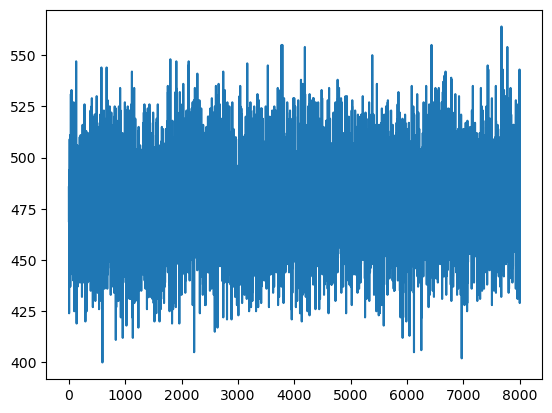

In [23]:
# Assign macro times to micro times
alex_period = 8000 # Alex period in macro time clocks
tttr.alex_to_microtime(alex_period)

mt_bin_count = np.bincount(tttr.micro_times)
plt.plot(mt_bin_count)
plt.show()

# Select bursts in tttr files

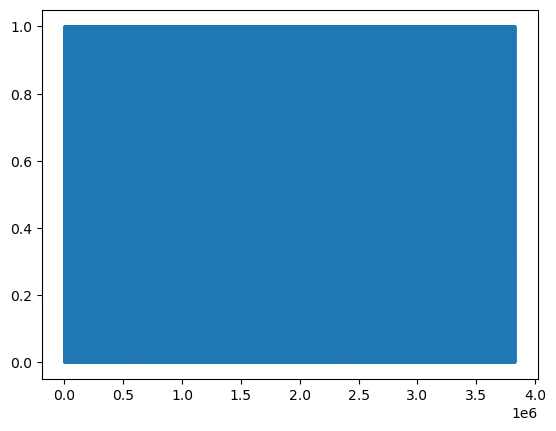

In [24]:
burst_mt_range = [(0, 8000)]

filter_options = {
    'min_ph': min_ph,
    'ph_window': ph_window,
    'tw': dT_max
}

s = select_photons(tttr, channels, dT_max, burst_mt_range, **filter_options)
plt.plot(s)

In [25]:
if channels:
    paris_path = pathlib.Path('burstwise' + "_" +  "-".join([str(x) for x in channels]) + f" {dT_max:.4f}#{min_ph}")
else:
    paris_path = pathlib.Path('burstwise' + "_" +  "All" + f" {dT_max:.4f}#{min_ph}")    
bur_path = file_path / paris_path / 'bur'
bur_path.mkdir(exist_ok=True, parents=True)
files_df = list()
for filename in tqdm.tqdm(files):
    print(filename)
    tttr = tttrlib.TTTR(filename.as_posix()) #, tttr_file_type)
    tttr.alex_to_microtime(8000)
    s = select_photons(tttr, channels, dT_max, burst_mt_range, **filter_options)
    start_stop = find_bursts(s, max_gap)
    bur_filename = bur_path / pathlib.Path(filename.stem + ".bur")
    df = write_bur_file(bur_filename, start_stop, filename.name, tttr, pie_windows, detectors)
    files_df.append(df)
df = pd.concat(files_df)
df.to_csv(bur_filename, sep='\t', index=False)

  0%|          | 0/2 [00:00<?, ?it/s]

/Users/tpeulen/Downloads/Brick-Mic/DNA_Alexa488-ATTO543-300sec/test80basic_300sec_0.h5


 50%|█████     | 1/2 [00:02<00:02,  2.35s/it]

/Users/tpeulen/Downloads/Brick-Mic/DNA_Alexa488-ATTO543-300sec/test80basic_300sec_2.h5


100%|██████████| 2/2 [00:04<00:00,  2.33s/it]


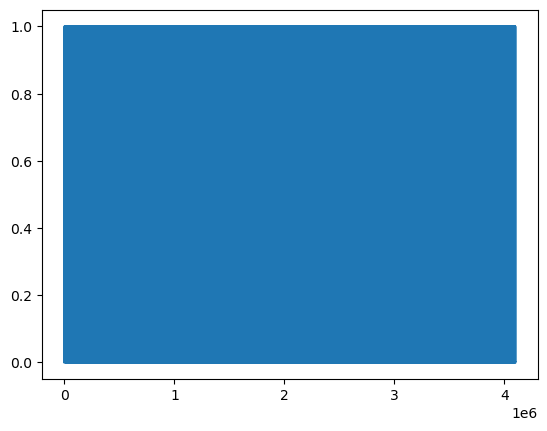

In [26]:
is_burst = np.diff(s, prepend=0, append=0)
plt.plot(s)

PosixPath('/Users/tpeulen/Downloads/Brick-Mic/DNA_Alexa488-ATTO543-300sec/test80basic_300sec_2.h5')

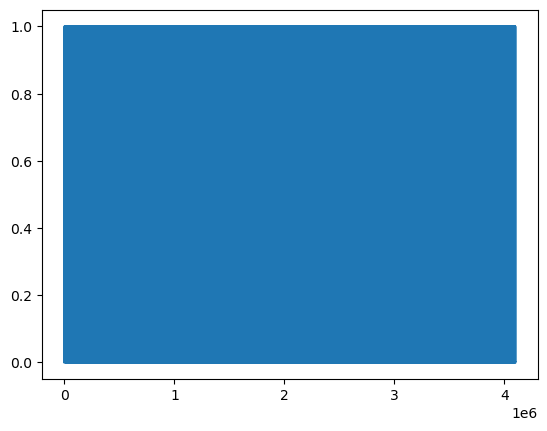

In [27]:
plt.plot(select_photons(tttr, channels, dT_max, burst_mt_range, **filter_options))
filename

In [28]:
tttr.get_macro_times()
tttr.get_micro_times()

array([ 103,  119,  129, ..., 7878, 7982, 7986], dtype=uint16)

In [29]:
start_stop = find_bursts(s, max_gap)
s

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

# Control plot

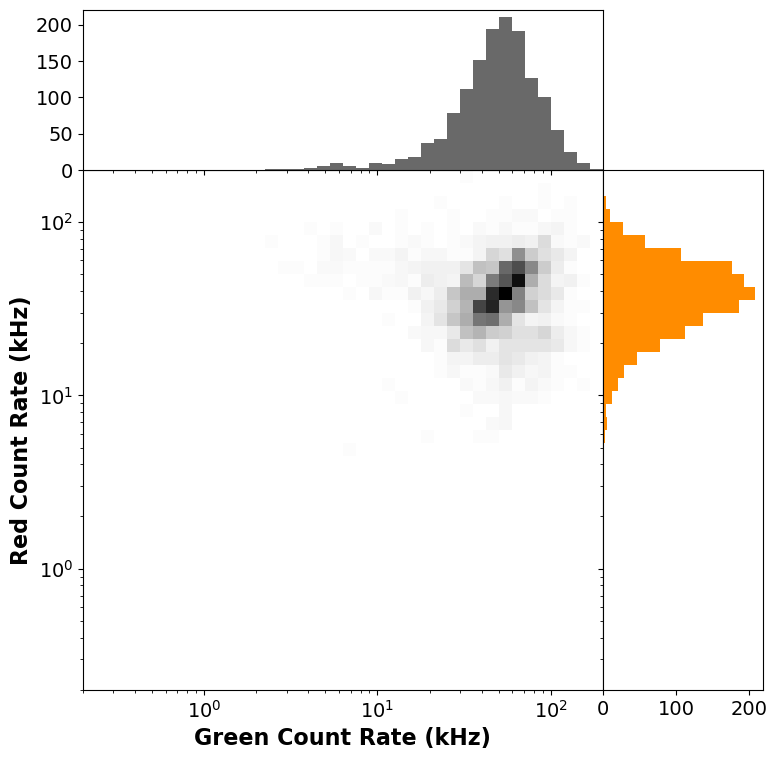

In [17]:
# Plot green/red count rate histogram
# Select parameter of interest & define axis range
x = df["Green Count Rate (KHz)"]
y = df["Red Count Rate (KHz)"]

xlabel = "Green Count Rate (kHz)"
ylabel = "Red Count Rate (kHz)"
range_x = [0.2, 200]
range_y = [0.2, 200]

make_2d_plot(
    x, y, range_x, range_y,
    file_path / paris_path,
    xlabel, 
    ylabel,
    bins_x = 41,
    bins_y = 41,
    log_x = True,
    log_y = True
)